In [1]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
import svmbir

olefile module not found


In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
# ncore = 48
# if ncore < mp.cpu_count():
ncore = mp.cpu_count()
ncore

256

# Workflow starts here!

In [4]:
###################### need to change start
ipts="30028"
###################### need to change end

## Find CT scan location

In [5]:
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ct_loc)

['2022_10_03_conceteA', '2022_10_03_conceteB']

## Find OB location

In [6]:
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ob_loc)

['2022_10_03_conceteB']

## Find DC location

In [7]:
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit"
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(dc_loc)

['2022_10_03_conceteB']

In [8]:
###################### need to change start
sample_name = "2022_10_03_conceteB"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_10_03_conceteB")
dc_dir = os.path.join(dc_loc, "2022_10_03_conceteB")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
end_ang = 359.1 # Will *NOT* be used if the CT file names contain angle info
ct_name = "*battery*" # Will not be used if follows the default file structure
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
output_hdf5_dir = "/netdisk/y9z/CG1D/IPTS-"+ipts+"/rockit/hdf5/"
# output_hdf5_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + sample_name + ".h5"
###################### need to change end

# Load all data files (CT, OB and DC)

In [9]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Found index of 180 degree projections: 545 of angle 179.85
Found index of 0 degree projections: 0 of angle 0.0
Loading 1091 CT projections...


1091it [00:35, 30.77it/s] 


1091 CT projections loaded!
Shape: (1091, 2048, 2048)
Loading 5 Open Beam (OB) images...


5it [00:00, 91.58it/s]


5 Open Beam (OB) images loaded!
Shape: (5, 2048, 2048)
Loading 5 Dark Current (DC) images...


5it [00:00, 256.74it/s]

5 Dark Current (DC) images loaded!
Shape: (5, 2048, 2048)


# Visual verification of loaded files

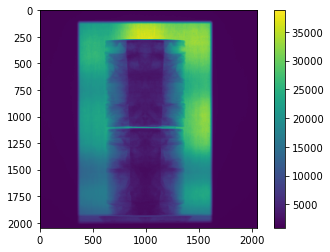

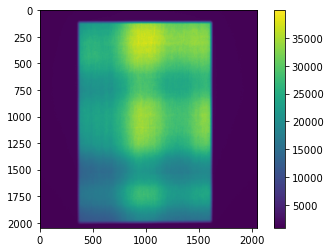

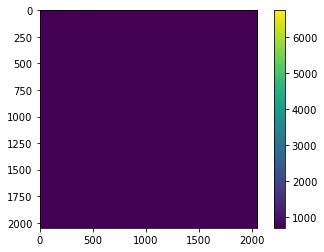

In [10]:
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(proj_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Define/crop ROI

Recon ROI:


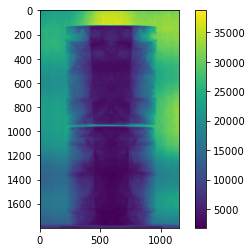

In [11]:
###################### need to change start
crop = True
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 400
crop_right = 1550
crop_top = 150
crop_bottom = 1950
###################### need to change end
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', crop)
if crop:
    history_dict = rocku.log(history_dict, 'crop_roi', crop_roi_dict)

# Remove Outliers

In [12]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

Time: 13.450429692165926 s


# Normalization

OB stack combined by median.
DC stack combined by median.
Normalizing...
Normalization Done!
float32
(1091, 1800, 1150)


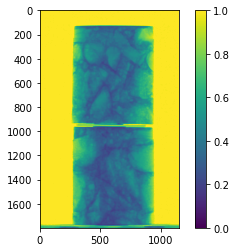

In [13]:
proj_norm, ob_med, dc_med = rocku.normalize(proj_crop, ob_crop, dc_crop)
print(proj_norm.dtype)
print(proj_norm.shape)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'normalization', True)

# Remove outliers again (optional)

proj_norm = tomopy.misc.corr.remove_outlier(proj_norm, gamma_diff, ncore=ncore)

# Beam fluctuation correction (optional)

Beam fluctuation ROI:


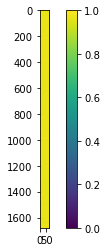

In [14]:
###################### need to change start
bg_left = 5
bg_right = 80
bg_top = 20
bg_bottom = 1700
###################### need to change end
bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

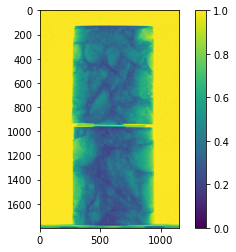

Time: 9.600981464143842 s


In [15]:
t0 = timeit.default_timer()
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
bg_roi_dict = {
    'left': bg_left,
    'right': bg_right,
    'top': bg_top,
    'bottom': bg_bottom
}
history_dict = rocku.log(history_dict, 'beam_fluc_corr', True)
history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi', bg_roi_dict)

# Minus log conversion

Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)Error.  nthreads must be a positive integer

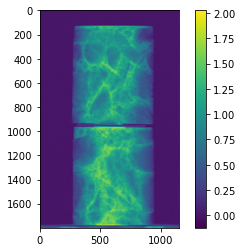

In [16]:
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'minus_log', True)

# Remove outliers again (optional)

proj_mlog = tomopy.misc.corr.remove_outlier(proj_norm, gamma_diff, ncore=ncore)

# Find and correct tilt

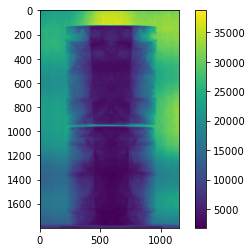

(1800, 1150)

In [17]:
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
proj_crop_min.shape

Tilt correction ROI at 0 degree:


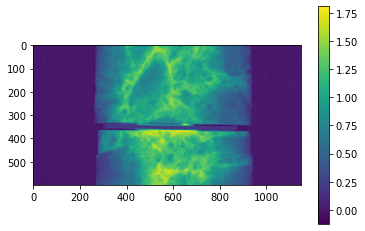

Tilt correction ROI at 180 degree (flipped):


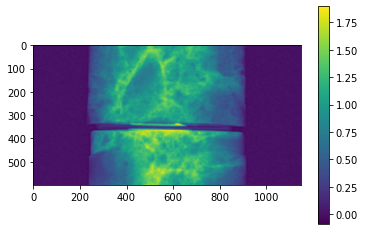

In [18]:
###################### need to change start
tt_left = 0
tt_right = 1500
tt_top = 600
tt_bottom = 1200
###################### need to change start
tt_roi_dict = {
    'left': tt_left,
    'right': tt_right,
    'top': tt_top,
    'bottom': tt_bottom
}
tt_000deg_mlog = proj_mlog[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_mlog = proj_mlog[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_000deg_trans = proj_norm[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_trans = proj_norm[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
print("Tilt correction ROI at 0 degree:")
# plt.imshow(tt_000deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_000deg_mlog)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree (flipped):")
# plt.imshow(tt_180deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(np.fliplr(tt_180deg_mlog))
plt.colorbar()
plt.show()

In [19]:
print("Finding the tilt angle using transmission images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_trans, image180=tt_180deg_trans)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using transmission images...
Found the tilt angle:  0.047863735355951925


In [20]:
print("Finding the tilt angle using minus log images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_mlog, image180=tt_180deg_mlog)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using minus log images...
Found the tilt angle:  0.04598208728520425


Projection at 0 degree:


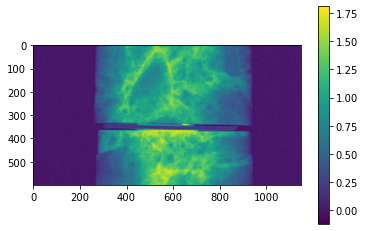

Projection at 180 degree (flipped):


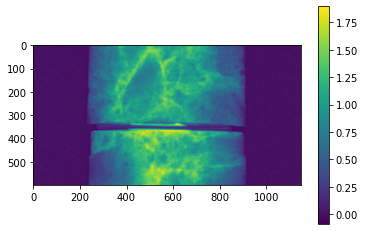

In [21]:
print("Projection at 0 degree:")
proj_mlog_tilt_000deg_mlog = tilt.apply_tilt_correction(tt_000deg_mlog, tilt_ang.x, ncore=ncore)
proj_mlog_tilt_180deg_mlog = tilt.apply_tilt_correction(tt_180deg_mlog, tilt_ang.x, ncore=ncore)
plt.imshow(proj_mlog_tilt_000deg_mlog)# vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Projection at 180 degree (flipped):")
plt.imshow(np.fliplr(proj_mlog_tilt_180deg_mlog))# vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [22]:
t0 = timeit.default_timer()
# tilt_ang.x = -0.7256422310429781
proj_mlog_tilt = proj_mlog[:]
for e_idx in range(proj_mlog.shape[0]):
    proj_mlog_tilt[e_idx] = tilt.apply_tilt_correction(proj_mlog[e_idx], tilt_ang.x, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'tilt_corr_roi', tt_roi_dict)
history_dict = rocku.log(history_dict, 'tilt_corr', tilt_ang.x)

Time cost 0.6670515921975796 min


# Ring Artifact Removal

Before ring removal:


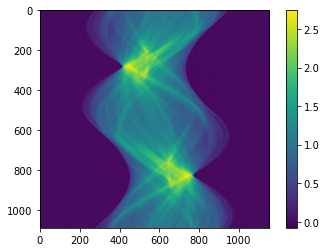

In [23]:
slice_num = 300
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (a) Vo's approach from tomopy (faster)

In [24]:
# nchunk = int(proj_mlog.shape[0]/ncore) + 1
# print("Chunk size: ", nchunk)
t0 = timeit.default_timer()
proj_mlog_rmv_vo = tomopy.remove_all_stripe(proj_mlog_tilt, 
                                            ncore=ncore, 
#                                             nchunk=nchunk
                                           )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'Vo')

Time cost 0.6537168305483647 min


Before ring removal:


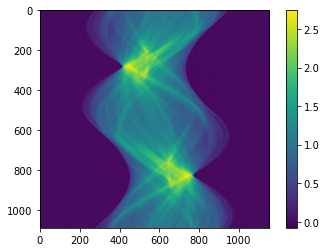

After ring removal:


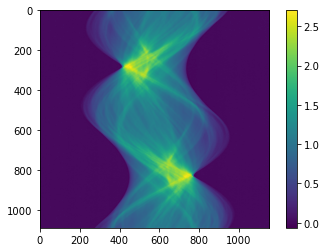

Difference:


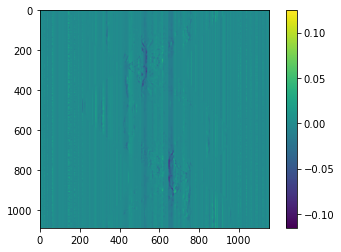

In [25]:
slice_num = 300
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (b) bm3d approach (slow, but generally better)

In [ ]:
t0 = timeit.default_timer()
print("Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.")
proj_mlog_bm3d = bm3d.extreme_streak_attenuation(proj_mlog_tilt)
print("Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.")
proj_mlog_rmv_bm3d = bm3d.multiscale_streak_removal(proj_mlog_bm3d)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'bm3d')

In [ ]:
slice_num = 300
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

# Find Center of Rotation

In [26]:
# proj_mlog_to_recon = proj_mlog_tilt[:]
proj_mlog_to_recon = proj_mlog_rmv_vo.astype(np.float32)
# proj_mlog_to_recon = proj_mlog_rmv_bm3d.astype(np.float32)
sino_norm = np.moveaxis(proj_norm, 1, 0)
sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)

In [27]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_mlog_to_recon[proj000_idx,:,:]), np.squeeze(proj_mlog_to_recon[proj180_idx,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 589.0


In [28]:
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center = calc.find_center_360(sino_mlog_to_recon[int(sino_mlog_to_recon.shape[0]/2)], win_width=800)[0]
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 588.5892343521118


# Reconstruction

## 1. Gridrec preview

Center of rotation 588.5892343521118
Time cost 0.004477737250272185 min


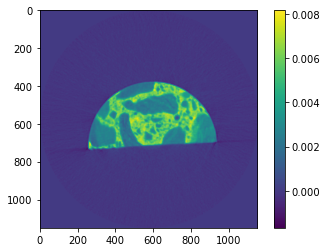

In [31]:
print("Center of rotation", rot_center)
t0 = timeit.default_timer()
rec_img1 = rec.gridrec_reconstruction(sino_mlog_to_recon[1600], rot_center, angles=ang_rad, apply_log=False,
                                      ratio=1.0,
                                      filter_name='shepp',
                                      pad=100,
                                      ncore=ncore
                                     )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 2. FBP preview

Center of rotation 588.5892343521118
Time cost 0.005458832636941224 min


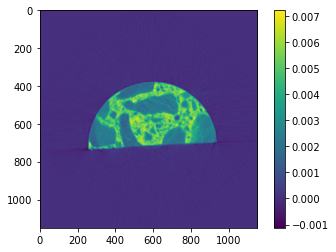

In [32]:
print("Center of rotation", rot_center)
t0 = timeit.default_timer()
rec_img1 = rec.fbp_reconstruction(sino_mlog_to_recon[1600], rot_center, angles=ang_rad, apply_log=False,
                                  ramp_win=None,
                                  filter_name='hann',
                                  pad=None,
                                  pad_mode='edge',
                                  ncore=ncore,
                                  gpu=False,
#                                   gpu=True, block=(16, 16), # Version error 7.8, current version 7.5
                                 )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 3. ASTRA preview

Center of rotation 588.5892343521118
Time cost 0.015705350782567015 min


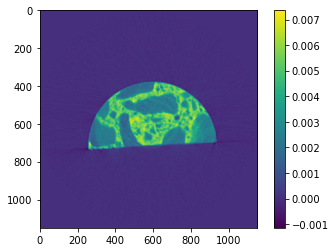

In [33]:
print("Center of rotation", rot_center)
# Reconstruction algorithms. 
# For CPU: 'FBP', 'SIRT', 'SART', 'ART', and CGLS'. 
# For GPU: 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', and 'CGLS_CUDA'.
t0 = timeit.default_timer()
rec_img1 = rec.astra_reconstruction(sino_mlog_to_recon[1600], rot_center, angles=ang_rad, apply_log=False,
#                                     method='SIRT_CUDA',
                                    method='FBP_CUDA',
                                    ratio=1.0,
                                    filter_name='hann',
                                    pad=None,
                                    num_iter=300,
                                    ncore=ncore
                                   )
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

## 4. svMBIR preview

Calling multires_recon for axial size (rows,cols)=(575,575).
Calling multires_recon for axial size (rows,cols)=(288,288).
Reconstructing axial size (rows,cols)=(288,288).
Found system matrix: /netdisk/y9z/svmbir_test/sysmatrix/bbf6abea0b5a40fe0208.2Dsvmatrix
Reconstructing axial size (rows,cols)=(575,575).
Found system matrix: /netdisk/y9z/svmbir_test/sysmatrix/25e7318fddb54697efc5.2Dsvmatrix
Reconstructing axial size (rows,cols)=(1150,1150).
Found system matrix: /netdisk/y9z/svmbir_test/sysmatrix/9bbd66576440534448c5.2Dsvmatrix
Time cost 0.8133926822183033 min


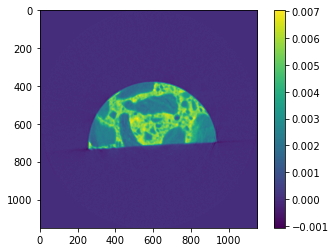

In [34]:
print("Center of rotation", rot_center)
T = 2.0
p = 1.2
sharpness = 0.0
snr_db = 30.0
center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
t0 = timeit.default_timer()
recon_mbir = svmbir.recon(proj_mlog_to_recon[:,1600,:],
                          angles=np.array(ang_rad), # In radians
                          weight_type='transmission', 
                          center_offset=center_offset, 
                          snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                          positivity=False,
                          max_iterations=100,
                          num_threads= 112,
                          verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
                          svmbir_lib_path = "/netdisk/y9z/svmbir_test",
                         )
recon_mbir = np.fliplr(np.rot90(recon_mbir, k=1, axes=(1,2)))
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
plt.imshow(recon_mbir[0])
plt.colorbar()
plt.show()

## Pick one method to recon

In [35]:
pix_um = 42 # um
recon_algo = 'gridrec'
# recon_algo = 'svmbir'

##################################
t0 = timeit.default_timer()
####################### tomopy algorithms (gridrec and fbp are faster than algotom) ##########################
if recon_algo in ['art', 'bart', 'fbp', 'gridrec',
                  'mlem', 'osem', 'ospml_hybrid', 'ospml_quad',
                  'pml_hybrid', 'pml_quad', 'sirt', 'tv', 'grad', 'tikh']:
    recon = tomopy.recon(proj_mlog_to_recon, ang_rad, center=rot_center,
                         algorithm=recon_algo,
                         ncore=ncore, 
#                          nchunk=nchunk
                        )
################################################ algotom algorithms ##########################################
    #### ASTRA
if recon_algo in ['FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', 'CGLS_CUDA']:
    recon = rec.astra_reconstruction(proj_mlog_to_recon, rot_center, angles=ang_rad, apply_log=False,
                                     method=recon_algo,
                                     num_iter=300,
                                     ncore=ncore
                                    )
    recon = np.moveaxis(recon, 1, 0) 
    #### gridrec from algotom
if recon_algo == 'gridrec_algo':
    recon = rec.gridrec_reconstruction(proj_mlog_to_recon, rot_center, angles=ang_rad, apply_log=False,
                                       ncore=ncore
                                      )
    recon = np.moveaxis(recon, 1, 0)
    #### FBP from algotom
if recon_algo == 'fbp_algo':
    recon = rec.fbp_reconstruction(proj_mlog_to_recon, rot_center, angles=ang_rad, apply_log=False,
                                   ncore=ncore,
                                   gpu=False,
#                                    gpu=True, # Version error 7.8, current version 7.5
                                  )
    recon = np.moveaxis(recon, 1, 0)
################################################### MBIR #####################################################
if recon_algo == 'svmbir':
    T = 2.0
    p = 1.2
    sharpness = 0.0
    snr_db = 30.0
    center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
    recon = svmbir.recon(
#         proj_mlog_to_recon,
        proj_mlog_to_recon[:,595:605,:],
        angles=np.array(ang_rad), # In radians
        weight_type='transmission', 
        center_offset=center_offset, 
        snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
        positivity=False,
        max_iterations=50,
        num_threads= 112,
        verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
        svmbir_lib_path = "/netdisk/y9z/svmbir_test",
    )
    recon = np.fliplr(np.rot90(recon, k=1, axes=(1,2)))
##################################
if pix_um is not None:
    pix_cm = pix_um/10000
    recon = recon/pix_cm
    history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
    recon_unit = "cm-1"
else:
    recon_unit = "px-1"
history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))

Time cost 0.14714552586665378 min


# Crop recon

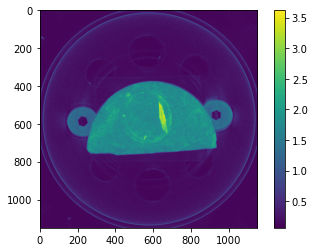

In [36]:
recon_max = np.max(recon, axis=0)
plt.imshow(recon_max)
plt.colorbar()
plt.show()

Recon ROI:


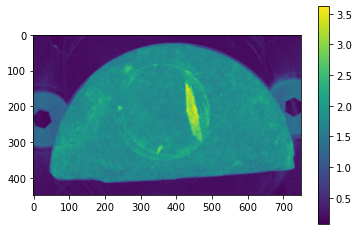

In [37]:
###################### need to change start
recon_crop = True
recon_crop_left = 200
recon_crop_right = 950
recon_crop_top = 350
recon_crop_bottom = 800
###################### need to change end
recon_max_crop = rocku.crop(recon_max, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
recon_crop_roi_dict = {
    'left': recon_crop_left,
    'right': recon_crop_right,
    'top': recon_crop_top,
    'bottom': recon_crop_bottom
}
print("Recon ROI:")
plt.imshow(recon_max_crop)
plt.colorbar()
plt.show()

In [38]:
recon = rocku.crop(recon, recon_crop_left, recon_crop_right, recon_crop_top, recon_crop_bottom, recon_crop)
history_dict = rocku.log(history_dict, 'recon_crop', recon_crop)
if recon_crop:
    history_dict = rocku.log(history_dict, 'recon_crop_roi', recon_crop_roi_dict)

# If [Memory Issue], recon & save, *slice by slice*

In [39]:
recon_algo = 'gridrec'
pix_um = None #um
save_to = None
#########################
if save_to is None:
    print("Input a location to save!")
else:
    t0 = timeit.default_timer()
    for h_idx in range(sino_mlog_to_recon.shape[0]):
        if recon_algo == 'gridrec':
            _rec_slice = rec.gridrec_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False,
                                                    ncore=ncore
                                                   )
        if recon_algo == 'fbp':
            _rec_slice = rec.fbp_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False,
                                                ncore=ncore,
                                                gpu=False,
    #                                             gpu=True, # Version error 7.8, current version 7.5
                                               )
        if recon_algo in ['FBP', 'SIRT', 'SART', 'ART', 'CGLS', 'FBP_CUDA', 'SIRT_CUDA', 'SART_CUDA', 'CGLS_CUDA']:
            _rec_slice = rec.astra_reconstruction(sino_mlog_to_recon[h_idx], rot_center, angles=ang_rad, apply_log=False,
                                                  method=recon_algo,
                                                  num_iter=300,
                                                  ncore=ncore)
        if recon_algo == 'svmbir':
            T = 2.0
            p = 1.2
            sharpness = 0.0
            snr_db = 30.0
            center_offset= -(proj_mlog_to_recon.shape[2]/2 - rot_center)
            _rec_mbir = svmbir.recon(proj_mlog_to_recon[:,h_idx,:],
                                      angles=np.array(ang_rad), # In radians
                                      weight_type='transmission', 
                                      center_offset=center_offset, 
                                      snr_db=snr_db, p=p, T=T, sharpness=sharpness, 
                                      positivity=False,
                                      max_iterations=100,
                                      num_threads= 112,
                                      verbose=1,# verbose: display of reconstruction: 0 is minimum, 1 is regular
                                      svmbir_lib_path = "/netdisk/y9z/svmbir_test"
                                     )
            _rec_slice = np.flipud(np.rot90(_rec_mbir[0]))
        if pix_um is not None:
            pix_cm = pix_um/10000
            _rec_slice = _rec_slice/pix_cm
        _slice_name = save_to + "/recon_" + f'{h_idx:05d}'
        print('Saving {} ...'.format(_slice_name))
        dxchange.write_tiff(_rec_slice, fname=_slice_name, overwrite=True)
    if pix_um is not None:
        history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)
        recon_unit = "cm-1"
    else:
        recon_unit = "px-1"
    history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)
    t1 = timeit.default_timer()
    print("Time cost {} min".format((t1-t0)/60))

Input a location to save!


# Export recon files

In [54]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name + "_all"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name
dxchange.write_tiff_stack(recon, fname=save_to + "/recon", overwrite=True, digit=4)

# Export to HDF5

In [40]:
history_dict

{'crop': True,
 'crop_roi': {'left': 400, 'right': 1550, 'top': 150, 'bottom': 1950},
 'gamma_filter': True,
 'normalization': True,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi': {'left': 5, 'right': 80, 'top': 20, 'bottom': 1700},
 'minus_log': True,
 'tilt_corr_roi': {'left': 0, 'right': 1500, 'top': 600, 'bottom': 1200},
 'tilt_corr': 0.04598208728520425,
 'ring_removal': 'Vo',
 'rot_center': 588.5892343521118,
 'pixel_size_um': 42,
 'recon_algo': 'gridrec',
 'recon_crop': True,
 'recon_crop_roi': {'left': 200, 'right': 950, 'top': 350, 'bottom': 800}}

In [56]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm', data=proj_norm)
    f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_dataset('tomo/proj/ob_fake', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_dataset('tomo/proj/dc_fake', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_norm', data=sino_norm)
    f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
    f.create_dataset('tomo/recon/recon_unit', data=(recon_unit,))
    f.create_dataset('tomo/recon/recon_volume', data=recon)